In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install gpytorch

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 15.4 MB/s eta 0:00:00


In [ ]:
from itertools import product
import math
import time
import glob
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as st
import torch
import gpytorch

In [ ]:
path='./drive/MyDrive/star_clusters_gen/data/'
files = glob.glob(path + 'sink*')
files

['./drive/MyDrive/star_clusters_gen/data/sink_m8.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m1.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m4.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m1.e5.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m9.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m2.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m3.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m1.e6.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m7.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m6.e4.dat',
 './drive/MyDrive/star_clusters_gen/data/sink_m5.e4.dat']

In [ ]:
N_CLUSTERS = None

def estimate_density(x, k=5):
    """Estimate the density of a dataset using the k-nearest neighbors method.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The dataset for which to estimate the density.
    k : int, optional (default=5)
        The number of nearest neighbors to use for density estimation.
    
    Returns
    -------
    densities : array, shape (n_samples,)
        The estimated densities for each sample in the dataset.
    """
    dens = np.zeros(len(x))

    # The volume of a unit d-dimensional ball is given by the formula
    d = len(x[0])
    volume = math.pi ** (d / 2) / math.gamma(d / 2 + 1)

    for i in range(len(x)):
      r  = np.sort(
          np.sqrt(
              np.sum([(x[:,j] - x[i][j])**2 for j in range(len(x[0]))], axis=0)
              )
          )[k]
      
      dens[i] = k/(volume * (r**d))
      #dens[i] = k/(r**2)

    return dens 



class Clusters:
    def __init__(self, dims, N=5000, path="./drive/MyDrive/star_clusters_gen/data/", generate=False, mean=None, cov=None):
      self.N = N
      self.dims = dims
      self.iter_train = 0
      self.iter_val = 0
      self.n_train = 7
      self.n_val = 3
      if generate:
        self._mean = [0]*self.dims if mean==None else mean
        self._cov = self.generate_random_spd_matrix() if cov==None else cov
        self.data = np.random.multivariate_normal(self._mean, self._cov, self.N)
      else:
        self.path = path
        files = glob.glob(path + 'sink*')
        global N_CLUSTERS
        N_CLUSTERS = len(files)
        self.data_train = np.empty((self.n_train,), dtype=np.ndarray)
        self.data_val = np.empty((self.n_val,), dtype=np.ndarray)
        self.names_train = []
        self.names_val = []
        for i in range(N_CLUSTERS):
          if i < self.n_train:
            self.data_train[i] = np.loadtxt(files[i], skiprows=1)
            self.names_train.append(files[i][-9:])
          else:
            self.data_val[i - self.n_train] = np.loadtxt(files[i], skiprows=1)
            self.names_val.append(files[i][-9:])

    def next_train(self, return_name=False):
        self.iter_train += 1
        if return_name:
          return self.data_train[(self.iter_train - 1)%self.n_train], self.names_train[(self.iter_train - 1)%self.n_train]
        else:
          return self.data_train[(self.iter_train - 1)%self.n_train]

    def next_val(self, idx, return_name=False):
        if return_name:
            return self.data_val[idx], self.names_val[idx]
        else:
            return self.data_val[idx]

    def count_stars_train(self):
        return np.sum([clusters.data_train[idx].shape[0] for idx in range(self.n_train)])

    def count_stars_val(self, idx):
        return clusters.data_val[idx].shape[0]    

    def generate_random_spd_matrix(self):
      # generate a random symmetric matrix
      A = np.random.rand(self.dims, self.dims)
      A = (A + A.T) / 2
      # ensure that the matrix is semi-positive definite by adding a multiple of the identity matrix
      I = np.eye(self.dims)
      A += 5 * I
      return A

    def subsample(self, n=300, plot=True):
       # select a random subsample
       idx = np.random.choice(np.arange(len(self.data)), n, False)
       x = self.data[idx]
       if plot and x.shape[1] == 2:
         plt.scatter(self.data[:,0], self.data[:,1], s=5)
         plt.scatter(x[:,0], x[:,1], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
         plt.colorbar()
         plt.show()
       return x

    def get_bounds(self, X):
        # Getter for the bounds of the density map in each dimension
        bounds = []
        for d in range(self.dims):
            bounds.append((min(X[:, d]), max(X[:, d])))
        return bounds
    
    def get_ave_bounds(self):
      add = False
      for j in range(7):
        c = self.next_train()
        if add:
          ave_bounds += np.array(self.get_bounds(c))
        else:
          ave_bounds = np.array(self.get_bounds(c))
          add = True
      return ave_bounds/7

class Cluster:
    def __init__(self, X, y, dim=7):
        # Store the density map and grid in the object
        self.dim = dim
        self.X = X
        self.y = y
        # Create a dictionary mapping elements to densities
        # self.map_dict = {}
        # for element, density in zip(grid, density_map):
        #     self.map_dict[tuple(element)] = density
    
    # def find_density(self, x):
    #     # Find the nearest element
    #     nearest_element = min(self.map_dict, 
    #                           key=lambda element: 
    #                           np.linalg.norm(np.array(element) - np.array(x)))
        
    #     # Return the density at the nearest element
    #     return self.map_dict[nearest_element]

    def get_bounds(self):
        # Getter for the bounds of the density map in each dimension
        bounds = []
        for d in range(self.dim):
            bounds.append((min(self.X[:, d]), max(self.X[:, d])))
        return bounds

    def get_max_density(self):
        return max(self.y)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(train_x[0].size()[0])
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(covar_x.size())
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class GP:
    def __init__(self, x, dims, k=5):
      self.dims = dims
      self.x = x
      self.train_x = torch.from_numpy(X)
      self.train_y = torch.from_numpy(estimate_density(X), k=k)
      self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
      self.model = ExactGPModel(train_x, train_y, likelihood)
      self.reshape_arr = None
      self.n_grid = None
      self.grid = None
      self.density_pred, self.cov_matrix, self.std = None, None, None
      self.x, self.grid = None, None

    def train(self, epochs=50):
      # find optimal model hyperparameters
      self.model.train()
      self.likelihood.train()

      # Use the adam optimizer, includes GaussianLikelihood parameters
      optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01) 

      # "Loss" for GPs - the marginal log likelihood
      mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

      for i in range(epochs):
          # Zero gradients from previous iteration
          optimizer.zero_grad()
          # Output from model
          output = self.model(self.train_x)
          # Calc loss and backprop gradients
          loss = -mll(output, self.train_y)
          loss.backward()
          print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
              i + 1, epochs, loss.item(),
              self.model.covar_module.base_kernel.lengthscale.item(),
              self.model.likelihood.noise.item()
          ))
          optimizer.step()
   

    def predict(self, num):
      self.n_grid = num
      self.reshape_arr = tuple([num]*self.dims)
      # Input space
      grid_elements = [np.linspace(self.x[:,j].min(), self.x[:,j].max(), num=num) for j in range(len(self.x[0]))]  
      self.grid = torch.from_numpy(np.array(list(product(*grid_elements))))

      f_preds = self.model(self.grid)
      y_preds = self.likelihood(self.f_preds)

      f_mean = f_preds.mean
      f_var = f_preds.variance
      self.cov_matrix = f_preds.covariance_matrix
      f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

      self.std = np.diag(self.cov_matrix)
      return self.density_pred, self.std

    def generate_posteriors(self, posterior_num, plot=True):
      self.posteriors = st.multivariate_normal.rvs(mean=self.density_pred,
                                              cov=self.cov_matrix,
                                              size=posterior_num)
      self.posteriors[self.posteriors < 0] = 0
      
      if posterior_num == 1:
        self.posteriors = [self.posteriors]

      if plot:
        Xp = []
        for i in range(self.grid.shape[1]):
          Xp.append(self.grid[:,i].reshape(self.reshape_arr))
        fig = plt.figure(figsize=(posterior_num * 6, 4))
        ax = [None] * posterior_num
        im = [None] * posterior_num
        for i, posterior in enumerate(self.posteriors):
          Z = np.reshape(posterior, self.reshape_arr)
          if self.dims == 2:
            ax[i] = fig.add_subplot(100 + posterior_num * 10 + i + 1)
            im[i] = ax[i].pcolormesh(Xp[0], Xp[1], Z, cmap="plasma")
          elif self.dims == 3:
            ax[i] = fig.add_subplot(100 + posterior_num * 10 + i + 1, projection='3d')
            im[i] = ax[i].scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z, alpha=0.15)
          fig.colorbar(im[i], ax=ax[i])
          ax[i].set_title(f"Generated density map #{i+1}")
        plt.show()
      return [DensityMap(posterior, np.array(self.grid)) for posterior in self.posteriors]

    def plot(self):
        Z_mean = np.reshape(self.density_pred, self.reshape_arr)
        Z_std = np.reshape(self.std, self.reshape_arr)
        Xp = []
        for i in range(self.grid.shape[1]):
          Xp.append(self.grid[:,i].reshape(self.reshape_arr))
        fig = plt.figure(figsize=(16,6))
        if self.dims == 2:
          ax_1 = fig.add_subplot(121)
          ax_2 = fig.add_subplot(122)
          im_1 = ax_1.pcolormesh(Xp[0], Xp[1], Z_mean, cmap="plasma")
          plt.colorbar(im_1, ax=ax_1)
          ax_1.scatter(self.x[:,0], self.x[:,1],s=self.n_grid)
          ax_1.set_title("Mean density heatmap")
          im_2 = ax_2.pcolormesh(Xp[0], Xp[1], Z_std, cmap="plasma")
          fig.colorbar(im_2, ax=ax_2)
          ax_2.scatter(self.x[:,0], self.x[:,1],s=self.n_grid)
          ax_2.set_title("Std dev heatmap")
          plt.show()
        if self.dims == 3:
          # creating 3d figures
          ax_1 = fig.add_subplot(121, projection='3d')
          ax_2 = fig.add_subplot(122, projection='3d')
          # configuring colorbar
          # color_map_1 = cm.ScalarMappable(cmap=cm.plasma)
          # color_map_1.set_array(Z_mean)
          # color_map_2 = cm.ScalarMappable(cmap=cm.plasma)
          # color_map_2.set_array(Z_std)  
          # creating the heatmap
          ax_1.scatter(self.x[:,0], self.x[:,1], self.x[:,2], marker='s', s=4)
          im_1 = ax_1.scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z_mean, alpha=0.15)
          fig.colorbar(im_1, ax=ax_1)
          ax_2.scatter(self.x[:,0], self.x[:,1], self.x[:,2], marker='s', s=4)
          im_2 = ax_2.scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z_std, alpha=0.15)
          fig.colorbar(im_2, ax=ax_2)  
          # adding title and labels
          ax_1.set_title("3D Mean Density Heatmap")
          ax_2.set_title("3D Std Dev Heatmap")
            
          # displaying plot
          plt.show()


## 2D

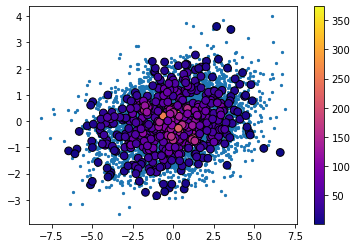

500


In [ ]:
DIMS = 2
NUM = 50
batch_size = 100

dg = DataManager(DIMS, generate=True, mean = [0,0], cov = [[5,0.6],[0.6,1]])
X = dg.subsample(n=500)
gp = GP(DIMS)
print(len(X))
# Iterate over minibatches of the data and update the Gaussian process model
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    #y_batch = y[i:i+batch_size]
    gp.fit_on_density(X_batch)

# gp.fit_on_density(X, k=5)
density_mean, density_std = gp.predict(NUM)

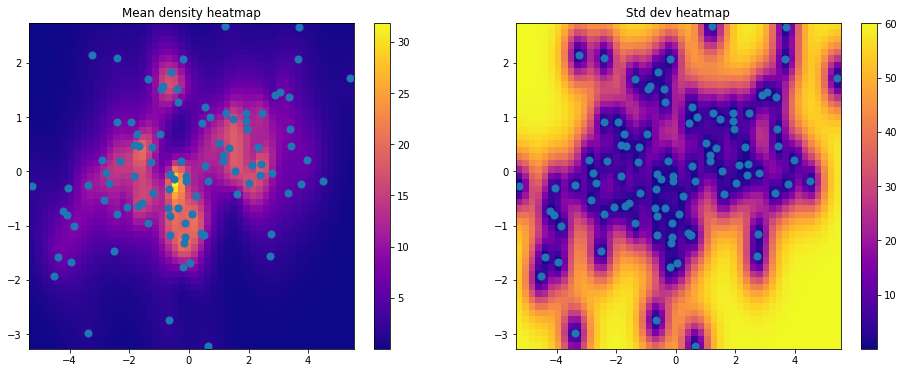

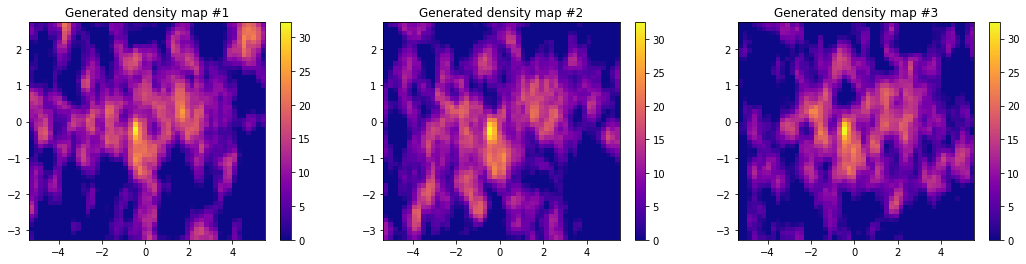

In [ ]:
gp.plot()
density_maps = gp.generate_posteriors(3)

## 3D

In [ ]:
DIMS = 3
NUM = 10

dg = DataManager(DIMS, generate=True)
X = dg.subsample(n=300)
gp = GP(DIMS)
gp.fit_on_density(X, k=5)
density_mean, density_std = gp.predict(NUM)

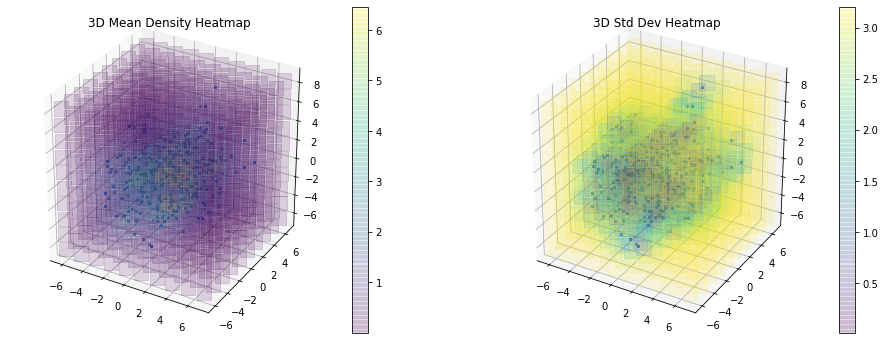

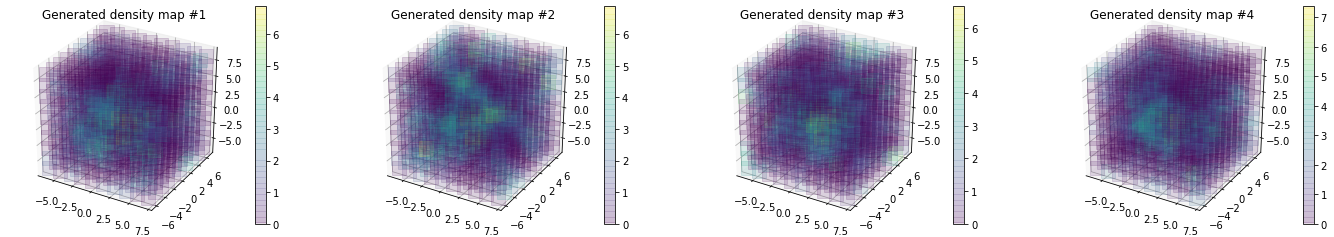

In [ ]:
gp.plot()
gp.generate_posteriors(4)

## Create new clusters by sampling in 2D

The choice of sampling method depends on the specific characteristics of the density map and the desired properties of the generated samples. 

**MCMC sampling** involves constructing a Markov chain whose stationary distribution is the target distribution. It generates samples by running the Markov chain for a sufficient number of steps and collecting samples from the chain. This method can be efficient if the Markov chain mixes well, but may be slow to converge to the stationary distribution. <br> <br>
*Pros:*
- Can be efficient if the Markov chain mixes well
- Can generate correlated samples
- Can sample from complex distributions<br>

*Cons:*
- May be slow to converge to the stationary distribution
- May require careful tuning of the Markov chain<br>

<br>

**Rejection sampling** involves generating samples uniformly at random from the sample space, and accepting them with a probability proportional to their density. This method can be inefficient if the density varies significantly across the sample space.<br>

*Pros:*
- Simple to implement
- Can handle high-dimensional sample spaces

*Cons:*
- Can be inefficient if the density varies significantly across the sample space
- Generates uncorrelated samples


In [ ]:
class Sampler:
    def __init__(self, model, likelihood, clusters, num_samples, random_seed, verbose=True):
        """
        Initialize the sampler.

        Parameters
        ----------
        model: ExactGP model
            The model we trained for generating new realizations.
        likelihood: Likelihood function
            The likelihood function we use to predict the density
        cluster: Cluster object
            Object containing information about the training cluster - todo: multiple clusters
        num_samples: int
            The number of samples to generate.
        random_seed: int
            The random seed used to initialize the random number generator.
        """
        model.eval()
        self.model = model
        likelihood.eval()
        self.likelihood = likelihood
        self.clusters = clusters
        self.num_samples = num_samples
        self.random_seed = random_seed
        self.num_dimensions = clusters.dims 
        self.verbose = verbose

    def _interpolate(self, point):
        """
        TODO? - i am not sure if it is needed - it depends on the grid step and
        the number of stars in the sample

        Use linear interpolation to estimate the density at a point.

        Parameters
        ----------
        point: array
            An array of shape (D,) containing the point at which to estimate the density.

        Returns
        -------
        density: float
            The estimated density at the point.
        """
        return

    def truncated_normal(self, mean, cov, size):
      """
      Generate samples from a truncated normal distribution.

      Parameters
      ----------
      mean: array
          An array of shape (D,) specifying the mean of the normal distribution.
      cov: float
          The covariance of the normal distribution.
      size: int
          The number of samples to generate.

      Returns
      -------
      samples: array
          An array of shape (size, D) containing the generated samples.
      """
      # initialize the samples array
      samples = np.zeros((size, len(mean)))

      #  specifying the bounds of the truncated normal distribution in each dimension.
      bounds = self.clusters.get_ave_bounds()

      # Generate samples from the truncated normal distribution in each dimension
      for d in range(len(mean)):
          a, b = bounds[d]
          mu = mean[d]
          sigma = cov[d] #if d else cov * 10
          samples[:, d] = st.truncnorm((a - mu) / sigma, (b - mu) / sigma, mu, sigma).rvs(size=size)

      return samples

    def predict_density(self, grid_point):
        grid_point = torch.from_numpy(grid_point).float().unsqueeze(0).cuda()
        f_preds = self.model(grid_point)
        y_preds = self.likelihood(self.model(grid_point))
        with torch.no_grad():
            return y_preds.mean[0].cpu().numpy()
        #return y_preds.sample()[0].cpu().numpy()


class MCMCSampler(Sampler):
    def sample(self, step_size=0.8, goback=False, random_walk=False, ref=None):
        """
        Generate samples from the density map using MCMC sampling*.
        * this is a modified version in which the previous value is not kept
        when a sample is rejected - the sampler iterates again until the counter
        reaches the number of desired samples.

        Returns
        -------
        samples: array
            An array of shape (num_samples, num_dimensions) containing the generated samples.
        """
        # initialize the samples array and set the initial sample, declare const
        samples = np.zeros((self.num_samples, self.num_dimensions))
        samples[0] = np.zeros(self.num_dimensions)
        attempts = 0
        density = self.predict_density(samples[0])
        prev_density = density.copy() 
        np.random.seed(self.random_seed)
        t0 = time.time()
        # run the MCMC sampler
        count = 1 if ref is None else 0
        while count < self.num_samples:
            attempts += 1
            if goback:
              return_point_idx = np.random.randint(0, count)
            if random_walk:
              if ref is None:
                step_size_p = np.random.uniform(0.000001, 0.05)
                step_size_v = np.random.uniform(0.0001, 0.01, 3)
                step_size_m = np.random.uniform(10, 50)
              else:
                step_size_p = np.random.uniform(0.000001, 0.01)
                step_size_v = np.random.uniform(0.00001, 0.01, 3)
                step_size_m = np.random.uniform(0.0001, 0.01)

              step_size = [step_size_p]*3 + list(step_size_v) + [step_size_m]
            if attempts > 20:
              for idx, s in enumerate(step_size):
                step_size[idx] = s * 10            

            if ref is None:
              sampling_center = samples[return_point_idx] if goback else samples[count-1]
            else:
              sampling_center = ref[count]
            
            # sample a new point from a truncated normal distribution centered at the current point
            new_point = self.truncated_normal(mean=sampling_center, cov=step_size, size=1)

            # the density at the new point
            density = self.predict_density(new_point)
 
            # the acceptance probability
            acceptance_prob = np.min([1.0, density / prev_density])

            # apply Metropolis algorithm to decide if accept the new point
            
            if self.verbose and count % 100 == 0:
                t1 = time.time()
                print('%d/%d generated samples [time: %.3f minutes]' % (count, self.num_samples, (t1-t0)/60))

            if np.random.rand() < acceptance_prob:
                samples[count] = new_point
                count +=1
                attempts = 0
                if ref is None:
                  prev_density = density.copy() 
                else:
                  prev_density = self.predict_density(ref[count])
            else:
                pass
                # samples[count] = samples[count - 1].copy()
                # p = np.random.choice(3, 1)[0]
                # samples[count][p + 1] = -samples[count][p + 1]
            
        return samples


class RejectionSampler(Sampler):
  def sample(self):
        """
        Generate samples from the density map using rejection sampling.

        Returns
        -------
        samples: array
            An array of shape (num_samples, num_dimensions) containing the generated samples.
        """

        # initialize, declare the sampler constants 

        max_density = 1
        bounds = self.clusters.get_ave_bounds()

        samples = np.zeros((self.num_samples, self.num_dimensions))
        samples[0] = np.zeros(self.num_dimensions)

        density = self.predict_density(samples[0])
        prev_density = density.copy() 
        np.random.seed(self.random_seed)

        t0 = time.time()
        # run the rejection sampler
        count = 1
        while count < self.num_samples:
            
            # sample a point uniformly at random from the sample space
            sample = []
            for d in range(self.num_dimensions):
                lower, upper = bounds[d]
                sample.append(np.random.uniform(lower, upper))

            # accept the sample with probability proportional to its density
            density = self.predict_density(np.array(sample))
            if density > max_density:
              max_density = density
            if np.random.rand() < density / max_density:
                samples[count] = sample
                count += 1
                if self.verbose and count % 100 == 0:
                  t1 = time.time()
                  print('%d/%d generated samples [time: %.3f minutes]' % (count, self.num_samples, (t1-t0)/60))
      

        return samples

In [ ]:
# data
DIMS = 7
clusters = Clusters(DIMS)

In [ ]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
X = clusters.next_train()
train_x = torch.from_numpy(X).float().cuda()
train_y = torch.from_numpy(estimate_density(X)).float().cuda()
model = ExactGPModel(train_x, train_y, likelihood).cuda()

Iter 1/800 - Loss: 17.126  -  lengthscale: 0.693 - noise: 0.693
*** VALIDATION  1/800 - Validation Loss 1: 86.004 - Normalized: 20.409   
*** VALIDATION  1/800 - Validation Loss 2: 26.172 - Normalized: 8.570   
*** VALIDATION  1/800 - Validation Loss 3: 35.614 - Normalized: 15.963   
Iter 2/800 - Loss: 36.220  -  lengthscale: 0.698 - noise: 0.698
Iter 3/800 - Loss: 55.156  -  lengthscale: 0.703 - noise: 0.703
Iter 4/800 - Loss: 54.672  -  lengthscale: 0.708 - noise: 0.708
Iter 5/800 - Loss: 14.391  -  lengthscale: 0.713 - noise: 0.713
Iter 6/800 - Loss: 20.181  -  lengthscale: 0.718 - noise: 0.717
Iter 7/800 - Loss: 90.316  -  lengthscale: 0.722 - noise: 0.722
Iter 8/800 - Loss: 14.403  -  lengthscale: 0.727 - noise: 0.726
*** VALIDATION  8/800 - Validation Loss 1: 75.657 - Normalized: 17.954   
*** VALIDATION  8/800 - Validation Loss 2: 22.368 - Normalized: 7.324   
*** VALIDATION  8/800 - Validation Loss 3: 31.403 - Normalized: 14.076   
Iter 9/800 - Loss: 31.163  -  lengthscale: 0.7

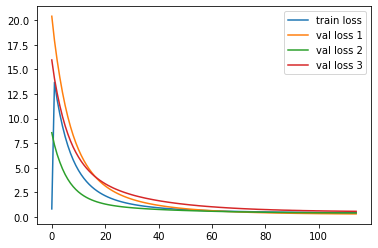

In [ ]:

timestamp = time.strftime("march%d_t%H%M", time.gmtime())
model = model.cuda()
likelihood = likelihood.cuda()

# Find optimal model hyperparameters
model.train()
likelihood.train()

val_loss = []
train_loss = []
train_loss_ = []

n_val = 3
n_test = 7

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 800
val_on = True
norm_train = 1000 / clusters.count_stars_train()
for i in range(training_iter):
    X = clusters.next_train()
    train_x = torch.from_numpy(X).float().cuda()
    train_y = torch.from_numpy(estimate_density(X)).float().cuda()
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    #print(output.sample())
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    norm_loss = loss.item() * norm_train
    print('Iter %d/%d - Loss: %.3f  -  lengthscale: %.3f - noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    train_loss_.append(norm_loss)
    if loss.item() < 0.01:
      break
    optimizer.step()
    if i % n_test == 0 and val_on:
      train_loss.append(np.sum(train_loss_))
      train_loss_ = []
      model.eval()
      likelihood.eval()
      val_loss_ = []
      for j in range(n_val):
        X = clusters.next_val(j)
        norm_val = 1000 / clusters.count_stars_val(j)
        val_x = torch.from_numpy(X).float().cuda()
        val_y = torch.from_numpy(estimate_density(X)).float().cuda()
        output = model(val_x)
        loss = -mll(output, val_y)
        val_loss_.append(loss.item() * norm_val)
        print('*** VALIDATION  %d/%d - Validation Loss %d: %.3f - Normalized: %.3f   ' % (
          i + 1, training_iter, j + 1, loss.item(), loss.item() * norm_val
        ))
      val_loss.append(val_loss_)
      model.train()
      likelihood.train()

val_loss = np.array(val_loss)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss[:, 0], label='val loss 1')
plt.plot(val_loss[:, 1], label='val loss 2')
plt.plot(val_loss[:, 2], label='val loss 3')
plt.legend()
plt.savefig(f'./drive/MyDrive/star_clusters_gen/{timestamp}.png')
plt.show()
torch.save(model.state_dict(), f'./drive/MyDrive/star_clusters_gen/{timestamp}.pth')


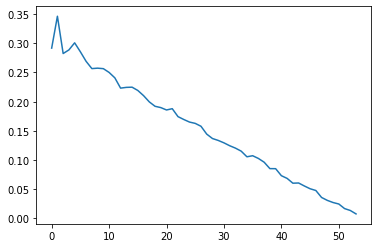

In [ ]:
plt.plot(train_loss_, label='train loss')

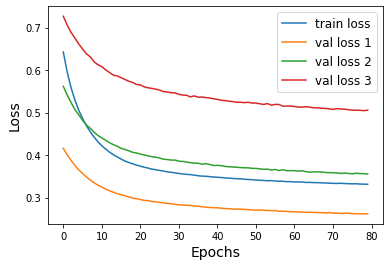

In [ ]:
plt.plot(train_loss[20:], label='train loss')
plt.plot(val_loss[20:][:, 0], label='val loss 1')
plt.plot(val_loss[20:][:, 1], label='val loss 2')
plt.plot(val_loss[20:][:, 2], label='val loss 3')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.savefig(f'./drive/MyDrive/star_clusters_gen/{timestamp}_cut.png')
plt.show()

In [ ]:
!ls ./drive/MyDrive/star_clusters_gen/

data		       march08_t1337_cut.png  march08_t1439.png
march08_t1241.png      march08_t1337.png      march08_t1439.pth
march08_t1241.pth      march08_t1416_150.pth  march09_t1310.cluster.npy
march08_t1337_100.pth  march08_t1416.png


In [ ]:
# Load saved model weights
checkpoint = torch.load('./drive/MyDrive/star_clusters_gen/march17_t1501.pth')

# Load weights into model
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
model.eval()
likelihood.eval()
X = clusters.next_train()
val_x = torch.from_numpy(X).float().cuda()
val_y = torch.from_numpy(estimate_density(X)).float().cuda()
f_preds = model(train_x)
y_preds = likelihood(f_preds)

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size([1,]))

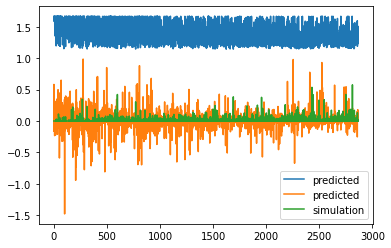

In [ ]:
with torch.no_grad():
  plt.plot(y_preds.variance.cpu().numpy(), label='predicted')
  plt.plot(y_preds.mean.cpu().numpy(), label='predicted')
  plt.plot(train_y.cpu(), label='simulation')
  
  plt.legend()

### MCMC sampling results

In [ ]:
timestamp = time.strftime("march%d_t%H%M", time.gmtime())
sampler = MCMCSampler(model, likelihood, clusters, 3500, random_seed=40)
step_size=0.5
samples = sampler.sample(step_size=step_size)
np.save(f'./drive/MyDrive/star_clusters_gen/{timestamp}_{step_size}.cluster', samples)
x = samples


# std t (min)
# 0.5 4.4
# 0.6 3.7
# 0.8 4.3
# 1.0 4.1
# 1.5 3.6



100/3500 generated samples [time: 0.155 minutes]
200/3500 generated samples [time: 0.309 minutes]
300/3500 generated samples [time: 0.461 minutes]
400/3500 generated samples [time: 0.590 minutes]
500/3500 generated samples [time: 0.737 minutes]
600/3500 generated samples [time: 0.896 minutes]
700/3500 generated samples [time: 1.036 minutes]
800/3500 generated samples [time: 1.193 minutes]
900/3500 generated samples [time: 1.352 minutes]
1000/3500 generated samples [time: 1.486 minutes]
1100/3500 generated samples [time: 1.642 minutes]
1200/3500 generated samples [time: 1.792 minutes]
1300/3500 generated samples [time: 1.912 minutes]
1400/3500 generated samples [time: 2.055 minutes]
1500/3500 generated samples [time: 2.175 minutes]
1600/3500 generated samples [time: 2.315 minutes]
1700/3500 generated samples [time: 2.466 minutes]
1800/3500 generated samples [time: 2.612 minutes]
1900/3500 generated samples [time: 2.755 minutes]
2000/3500 generated samples [time: 2.873 minutes]
2100/3500

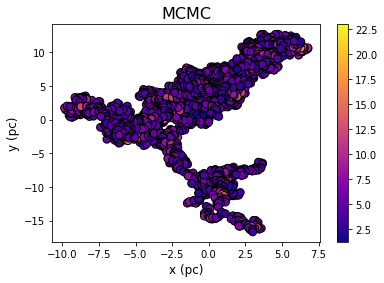

In [ ]:
plt.scatter(x[:,1], x[:,2], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
plt.colorbar()
plt.title('MCMC', fontsize=16)
plt.xlabel('x (pc)', fontsize=12)
plt.ylabel('y (pc)', fontsize=12)
plt.show()

In [ ]:
X = clusters.next_train()

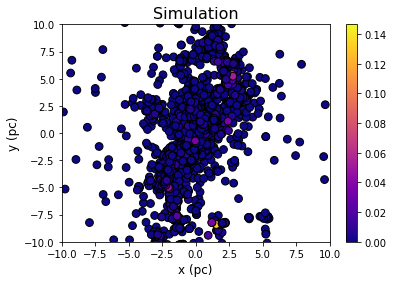

In [ ]:
plt.scatter(X[:,1], X[:,2], c=estimate_density(X), edgecolor="k",s=60,cmap="plasma")
plt.title('Simulation', fontsize=16)
plt.xlabel('x (pc)', fontsize=12)
plt.ylabel('y (pc)', fontsize=12)
plt.axis(xmin=-10,xmax=10,ymin=-10,ymax=10)
plt.colorbar()
plt.show()

(array([573., 668., 597., 422., 326., 262., 180., 170., 128., 103.]),
 array([0.4474946 , 1.40121717, 2.35493973, 3.30866229, 4.26238486,
        5.21610742, 6.16982999, 7.12355255, 8.07727512, 9.03099768,
        9.98472024]),
 <BarContainer object of 10 artists>)

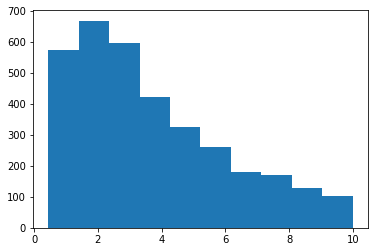

In [ ]:
Xm = abs(X)[:,0]
Xm = Xm[Xm<10]
plt.hist(Xm)

(array([4.074e+03, 1.030e+02, 2.400e+01, 6.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.4474946 ,  31.68820836,  62.92892212,  94.16963588,
        125.41034964, 156.6510634 , 187.89177716, 219.13249092,
        250.37320468, 281.61391845, 312.85463221]),
 <BarContainer object of 10 artists>)

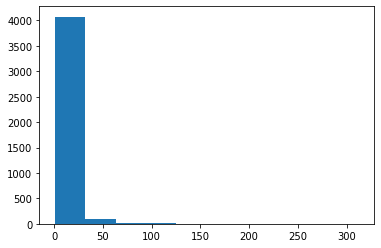

In [ ]:
plt.hist(abs(X)[:,0])

(array([308., 461., 810., 737., 477., 365., 210.,  50.,  45.,  37.]),
 array([ 0.        ,  1.05868882,  2.11737765,  3.17606647,  4.2347553 ,
         5.29344412,  6.35213295,  7.41082177,  8.4695106 ,  9.52819942,
        10.58688824]),
 <BarContainer object of 10 artists>)

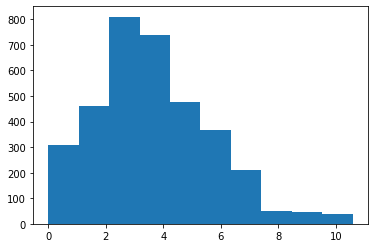

In [ ]:
plt.hist(abs(x)[:,0])

## MCMC GoBack

In [ ]:
print(name)
print(len(X))

m1.e4.dat
2523


In [ ]:
timestamp = time.strftime("march%d_t%H%M", time.gmtime())
N = len(X) - 1 
sampler = MCMCSampler(model, likelihood, clusters, N, random_seed=40)
step_size=1.0
samples = sampler.sample(step_size=step_size, goback=False, random_walk=True, ref=X)
np.save(f'./drive/MyDrive/star_clusters_gen/{timestamp}_{step_size}.cluster_goback', samples)
x = samples
# 0.5  5.4
# 0.7 5.5   1.3
# 1.0 6.4   1.3
# 1.2 6.9

0/2522 generated samples [time: 0.005 minutes]
100/2522 generated samples [time: 0.254 minutes]
200/2522 generated samples [time: 0.472 minutes]
300/2522 generated samples [time: 0.718 minutes]
400/2522 generated samples [time: 0.942 minutes]
400/2522 generated samples [time: 0.943 minutes]
500/2522 generated samples [time: 1.168 minutes]
600/2522 generated samples [time: 1.388 minutes]
700/2522 generated samples [time: 1.614 minutes]
800/2522 generated samples [time: 1.842 minutes]
800/2522 generated samples [time: 1.843 minutes]
800/2522 generated samples [time: 1.845 minutes]
900/2522 generated samples [time: 2.075 minutes]
1000/2522 generated samples [time: 2.311 minutes]
1100/2522 generated samples [time: 2.546 minutes]
1200/2522 generated samples [time: 2.771 minutes]
1300/2522 generated samples [time: 2.997 minutes]
1400/2522 generated samples [time: 3.225 minutes]
1500/2522 generated samples [time: 3.452 minutes]
1600/2522 generated samples [time: 3.684 minutes]
1700/2522 gener

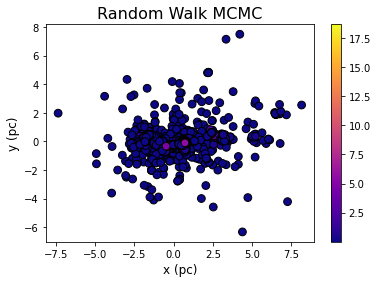

In [ ]:
plt.scatter(x[:,1],x[:,2], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
plt.colorbar()
plt.title('Random Walk MCMC', fontsize=16)
plt.xlabel('x (pc)', fontsize=12)
plt.ylabel('y (pc)', fontsize=12)
plt.show()

### Rejection sampling results

In [ ]:
timestamp = time.strftime("march%d_t%H%M", time.gmtime())
sampler = RejectionSampler(model, likelihood, clusters, 3500, random_seed=40)
samples = sampler.sample()
np.save(f'./drive/MyDrive/star_clusters_gen/{timestamp}.cluster_rej', samples)
x = samples

100/3500 generated samples [time: 0.488 minutes]
200/3500 generated samples [time: 0.959 minutes]
300/3500 generated samples [time: 1.453 minutes]
400/3500 generated samples [time: 1.925 minutes]
500/3500 generated samples [time: 2.339 minutes]
600/3500 generated samples [time: 2.816 minutes]
700/3500 generated samples [time: 3.278 minutes]
800/3500 generated samples [time: 3.687 minutes]
900/3500 generated samples [time: 4.107 minutes]
1000/3500 generated samples [time: 4.469 minutes]
1100/3500 generated samples [time: 4.901 minutes]
1200/3500 generated samples [time: 5.286 minutes]
1300/3500 generated samples [time: 5.656 minutes]
1400/3500 generated samples [time: 6.141 minutes]
1500/3500 generated samples [time: 6.568 minutes]
1600/3500 generated samples [time: 6.955 minutes]
1700/3500 generated samples [time: 7.329 minutes]
1800/3500 generated samples [time: 7.769 minutes]
1900/3500 generated samples [time: 8.177 minutes]
2000/3500 generated samples [time: 8.574 minutes]
2100/3500

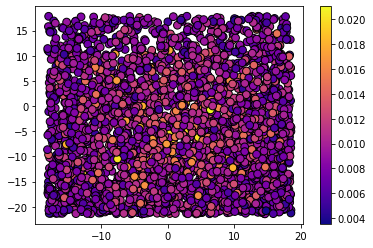

In [ ]:
plt.scatter(x[:,1], x[:,2], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
plt.colorbar()
plt.show()

## Properties

In [ ]:
!ls ./drive/MyDrive/star_clusters_gen/

data				   march09_t2206_0.5.cluster_goback.npy
march08_t1241.png		   march09_t2215_1.5.cluster_goback.npy
march08_t1241.pth		   march09_t2230_1.0.cluster_goback.npy
march08_t1337_100.pth		   march10_t0917_1.0.cluster_goback.npy
march08_t1337_cut.png		   march10_t0929_0.5.cluster_goback.npy
march08_t1337.png		   march10_t0935_0.7.cluster_goback.npy
march08_t1416_150.pth		   march10_t0943_1.2.cluster_goback.npy
march08_t1416.png		   march10_t1053_1.0.cluster_goback.npy
march08_t1439.png		   march10_t1100_0.5.cluster_goback.npy
march08_t1439.pth		   march10_t1110_1.0.cluster_goback.npy
march09_t1447_0.3.cluster.npy	   march10_t1117_0.5.cluster.npy
march09_t1453_0.5.cluster.npy	   march10_t1213.cluster_rej.npy
march09_t1536_0.1.cluster.npy	   march10_t1332_1.0_2500.cluster_goback.npy
march09_t1558_0.4.cluster.npy	   march10_t1346_1.0_3000.cluster_goback.npy
march09_t1832_0.5.cluster_rej.npy  MCMC0.5.png


Inter-particle distances

In [ ]:
X, name = clusters.next_train(return_name=True)
X2, name2 = clusters.next_train(return_name=True)

In [ ]:
c1 = np.load(f'./drive/MyDrive/star_clusters_gen/march09_t1832_0.5.cluster_rej.npy')
c2 = np.load(f'./drive/MyDrive/star_clusters_gen/march09_t1453_0.5.cluster.npy')
c3 = x#np.load(f'./drive/MyDrive/star_clusters_gen/march10_t1110_1.0.cluster_goback.npy')

In [ ]:
c3[:,1].shape
distances_c3 = pdist(np.column_stack((c1[:,1], c1[:,2], c1[:,3])))
min(distances_c3)

0.10190293556137543

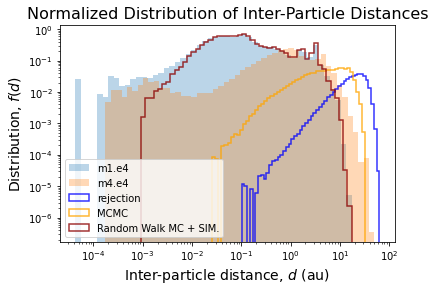

In [ ]:
from scipy.spatial.distance import pdist
distances_1 = pdist(np.column_stack((X[:,1], X[:,2], X[:,3])))
distances_2 = pdist(np.column_stack((X2[:,1], X2[:,2], X2[:,3])))
distances_c1 = pdist(np.column_stack((c1[:,1], c1[:,2], c1[:,3]))) 
distances_c2 = pdist(np.column_stack((c2[:,1], c2[:,2], c2[:,3]))) 
distances_c3 = pdist(np.column_stack((c3[:,1], c3[:,2], c3[:,3])))
# Create the histogram
hist, bins = np.histogram(distances_1, bins=50, density=True)
hist2, bins2 = np.histogram(distances_2, bins=50, density=True)
histc1, binsc1 = np.histogram(distances_c1, bins=50, density=True)
histc2, binsc2 = np.histogram(distances_c2, bins=50, density=True)
histc3, binsc3 = np.histogram(distances_c3, bins=50, density=True)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
logbins2 = np.logspace(np.log10(bins2[0]), np.log10(bins2[-1]), len(bins2))
logbinsc1 = np.logspace(np.log10(binsc1[0]), np.log10(binsc1[-1]), len(binsc1))
logbinsc2 = np.logspace(np.log10(binsc2[0]), np.log10(binsc2[-1]), len(binsc2))
logbinsc3 = np.logspace(np.log10(binsc3[0]), np.log10(binsc3[-1]), len(binsc3))
plt.hist(distances_1, bins=logbins, alpha=0.3, density=True, label=name[:-4])
plt.hist(distances_2, bins=logbins2, alpha=0.3, density=True, label=name2[:-4])
plt.hist(distances_c1, bins=logbinsc1, alpha=0.8, density=True, edgecolor='blue', linewidth=1.5, histtype='step', label='rejection')
plt.hist(distances_c2, bins=logbinsc2, alpha=0.8, density=True, edgecolor='orange', linewidth=1.5, histtype='step', label='MCMC')
plt.hist(distances_c3, bins=logbinsc3, alpha=0.8, density=True, edgecolor='darkred', linewidth=1.5, histtype='step', label='Random Walk MC + SIM.')
# Set the axis labels and title
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Inter-particle distance, $d$ (au)', fontsize=14)
#plt.axis(xmin=1e-4)
plt.ylabel(r'Distribution, $f(d)$', fontsize=14)
plt.title('Normalized Distribution of Inter-Particle Distances', fontsize=16)
plt.legend(loc='lower left')
# Show the plot
plt.show()

Velocities

In [ ]:
c1 = c1[1:]
c2 = c2[1:]
c3 = c3[1:]

<ipython-input-58-c4dc5b546d15>:15: RuntimeWarning: divide by zero encountered in log10
  logbinsc2 = np.logspace(np.log10(binsc2[0]), np.log10(binsc2[-1]), len(binsc2))


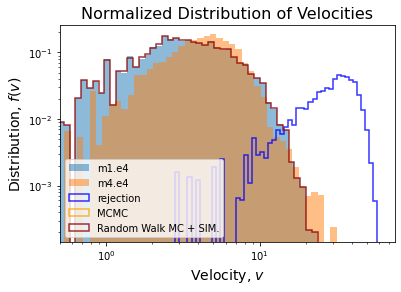

In [ ]:

v = np.sqrt(X[:, 4]**2 + X[:, 5]**2 + X[:, 6]**2)
v2 = np.sqrt(X2[:, 4]**2 + X2[:, 5]**2 + X2[:, 6]**2)
vc1 = np.sqrt(c1[:, 4]**2 + c1[:, 5]**2 + c1[:, 6]**2)
vc2 = np.sqrt(c2[:, 4]**2 + c2[:, 5]**2 + c2[:, 6]**2)
vc3 = np.sqrt(c3[:, 4]**2 + c3[:, 5]**2 + c3[:, 6]**2)
# Create the histogram
hist, bins = np.histogram(v, bins=50, density=True)
hist2, bins2 = np.histogram(v2, bins=50, density=True)
histc1, binsc1 = np.histogram(vc1, bins=50, density=True)
histc2, binsc2 = np.histogram(vc2, bins=50, density=True)
histc3, binsc3 = np.histogram(vc3, bins=50, density=True)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
logbins2 = np.logspace(np.log10(bins2[0]), np.log10(bins2[-1]), len(bins2))
logbinsc1 = np.logspace(np.log10(binsc1[0]), np.log10(binsc1[-1]), len(binsc1))
logbinsc2 = np.logspace(np.log10(binsc2[0]), np.log10(binsc2[-1]), len(binsc2))
logbinsc3 = np.logspace(np.log10(binsc3[0]), np.log10(binsc3[-1]), len(binsc3))
plt.hist(v, bins=logbins, alpha=0.5, density=True, label=name[:-4])
plt.hist(v2, bins=logbins2, alpha=0.5, density=True, label=name2[:-4])
plt.hist(vc1, bins=logbinsc1, alpha=0.8, density=True, edgecolor='blue', linewidth=1.5, histtype='step', label='rejection')
plt.hist(vc2, bins=logbinsc2, alpha=0.8, density=True, edgecolor='orange', linewidth=1.5, histtype='step', label='MCMC')
plt.hist(vc3, bins=logbinsc3, alpha=0.8, density=True, edgecolor='darkred', linewidth=1.5, histtype='step', label='Random Walk MC + SIM.')

# Set the axis labels and title
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Velocity, $v$', fontsize=14)
plt.axis(xmin=0.5)
plt.ylabel(r'Distribution, $f(v)$', fontsize=14)
plt.title('Normalized Distribution of Velocities', fontsize=16)
plt.legend(loc='lower left')
# Show the plot
plt.show()

Mass

<ipython-input-59-c4592855b75a>:16: RuntimeWarning: divide by zero encountered in log10
  logbinsc2 = np.logspace(np.log10(binsc2[0]), np.log10(binsc2[-1]), len(binsc2))


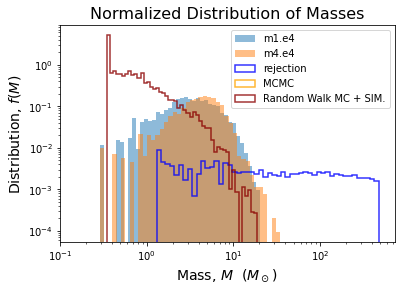

In [ ]:

m = X[:,0]
m2 = X2[:,0]
mc1 = c1[:,0]
mc2 = c2[:,0]
mc3 = c3[:,0]
# Create the histogram
hist, bins = np.histogram(m, bins=50, density=True)
hist2, bins2 = np.histogram(m2, bins=50, density=True)

histc1, binsc1 = np.histogram(mc1, bins=50, density=True)
histc2, binsc2 = np.histogram(mc2, bins=50, density=True)
histc3, binsc3 = np.histogram(mc3, bins=50, density=True)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
logbins2 = np.logspace(np.log10(bins2[0]), np.log10(bins2[-1]), len(bins2))
logbinsc1 = np.logspace(np.log10(binsc1[0]), np.log10(binsc1[-1]), len(binsc1))
logbinsc2 = np.logspace(np.log10(binsc2[0]), np.log10(binsc2[-1]), len(binsc2))
logbinsc3 = np.logspace(np.log10(binsc3[0]), np.log10(binsc3[-1]), len(binsc3))


plt.hist(v, bins=logbins, alpha=0.5, density=True, label=name[:-4])
plt.hist(v2, bins=logbins2, alpha=0.5, density=True, label=name2[:-4])
plt.hist(mc1, bins=logbinsc1, alpha=0.8, density=True, edgecolor='blue', linewidth=1.5, histtype='step', label='rejection')
plt.hist(mc2, bins=logbinsc2, alpha=0.8, density=True, edgecolor='orange', linewidth=1.5, histtype='step', label='MCMC')
plt.hist(mc3, bins=logbinsc3, alpha=0.8, density=True, edgecolor='darkred', linewidth=1.5, histtype='step', label='Random Walk MC + SIM.')

# Set the axis labels and title
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass, $M$  ($M_\odot$) ', fontsize=14)
plt.axis(xmin=0.1)
plt.ylabel(r'Distribution, $f(M)$', fontsize=14)
plt.title('Normalized Distribution of Masses', fontsize=16)
plt.legend()
# Show the plot
plt.show()

Shape Parameter

In [ ]:
from scipy.stats import vonmises

def shape_parameter(c):
    x, y, z = c[:, 1], c[:, 2], c[:, 3]
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mean_z = np.mean(z)
    dx = x - mean_x
    dy = y - mean_y
    dz = z - mean_z
    directions = np.column_stack((dx, dy, dz))
    norms = np.sqrt(np.sum(directions**2, axis=1))
    normalized_directions = directions / norms[:, np.newaxis]
    angles = np.arccos(normalized_directions[:, 2])
    angles_unwrapped = np.unwrap(angles)
    kappa, _, _ = vonmises.fit(angles_unwrapped)
    return kappa


Virial Ratio

In [ ]:
# Compute the pairwise distances and the potential energy
from scipy.spatial.distance import pdist, squareform
def virial_ratio(c):
    M = c[:, 0]
    M_solar = 2e30
    grav_const = 6.6743e-11
    pc = 3.08567758e16 
    km = 1000
    distances = squareform(pdist(np.column_stack((c[:, 1], c[:, 2], c[:, 3]))))
    np.fill_diagonal(distances, np.inf)
    potential = np.sum(M[None, :] * M[:, None] * (M_solar**2) * grav_const / (distances*pc)) / 2
    
    # Compute the kinetic energy
    velocities = np.column_stack((c[:, 4], c[:, 5], c[:, 6]))
    speeds = np.linalg.norm(velocities, axis=1)
    kinetic = 0.5 * np.sum(M * M_solar * (speeds*km)**2)

    # Compute the virial ratio
    virial_ratio = 2 * kinetic / potential
    return virial_ratio

## Generating synthetic clusters with MCMC GoBack

In [ ]:
timestamp = time.strftime("march%d_t%H%M", time.gmtime())
N = 2500
sampler = MCMCSampler(model, likelihood, clusters, N, random_seed=40)
step_size=1.0
samples = sampler.sample(step_size=step_size, goback=True)
np.save(f'./drive/MyDrive/star_clusters_gen/{timestamp}_{step_size}_{N}.cluster_goback', samples)
x = samples

100/2500 generated samples [time: 0.457 minutes]
100/2500 generated samples [time: 0.459 minutes]
100/2500 generated samples [time: 0.461 minutes]
100/2500 generated samples [time: 0.462 minutes]
100/2500 generated samples [time: 0.465 minutes]
200/2500 generated samples [time: 0.859 minutes]
200/2500 generated samples [time: 0.860 minutes]
200/2500 generated samples [time: 0.861 minutes]
200/2500 generated samples [time: 0.863 minutes]
200/2500 generated samples [time: 0.864 minutes]
200/2500 generated samples [time: 0.865 minutes]
300/2500 generated samples [time: 1.216 minutes]
400/2500 generated samples [time: 1.569 minutes]


KeyboardInterrupt: ignored

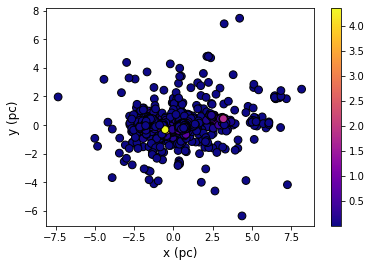

In [ ]:
plt.scatter(x[:,1], x[:,2], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
plt.colorbar()
plt.xlabel('x (pc)', fontsize=12)
plt.ylabel('y (pc)', fontsize=12)
plt.show()

In [ ]:
print(np.sum(x[:,0]))
print(shape_parameter(x))
print(virial_ratio(x))

4253.777234904088
0.03493619141301665
1.493208920033078


In [ ]:
xx = np.load(f'./drive/MyDrive/star_clusters_gen/march18_t2210_1.0.cluster_goback.npy')

In [ ]:
print(np.sum(xx[:,0]))
print(shape_parameter(xx))
print(virial_ratio(xx))

4766.320145823074
1.5503425954408203
32.91567454450566
